In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [4]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset

device = torch.device("cpu")
num_clients = 4

proportion = 10
data = balance_dataset(data, proportion)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 


In [5]:

# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join":  0.8,
    "S_0": 1e-8,
    "c_max": 10,
    "device": torch.device("cpu")
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 10,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


Client 1: {0: 867, 1: 80}
Client 2: {0: 861, 1: 86}
Client 3: {0: 855, 1: 92}
Client 4: {0: 851, 1: 96}
Test Set: {0: 1486, 1: 138}

Combined Number of Samples per Class:
Class 0: 4920 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 5412


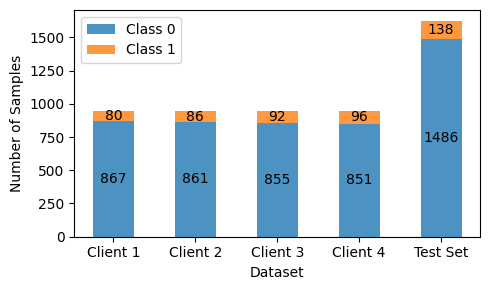

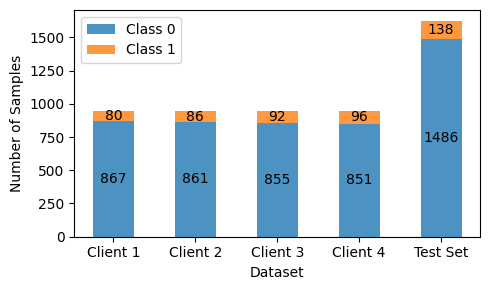

In [6]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
plot_dataset_split(client_train, test_data)

In [7]:
import utils.utils_train
from utils.utils_train import train_supervised, calculate_metrics, plot_confusion_matrix, calculate_roc_auc
from utils.utils_plots import plot_first_feature

if False:
    
    # Assuming models and client_data are already defined
    for client_idx, client_model in enumerate(local_models):
        print(f"Training model for client {client_idx + 1}")
        train_supervised(client_model, client_train[client_idx]) 
        plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [8]:
import utils.utils_train
from utils.utils_train import train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train)


Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Processed 947 points.Number of clusters: 90
Processed 947 points.Number of clusters: 72
Processed 947 points.Number of clusters: 87
Processed 947 points.Number of clusters: 96


In [9]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    all_scores, pred_max = test_model(client_model, test_data)
    metrics = calculate_metrics(pred_max, test_data)
    #test_model(client_model, all_data)
    print(f"Test Metrics: {metrics}")
    
    


Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9187192118226601, 'precision': 0.9236175714729694, 'recall': 0.9187192118226601, 'f1_score': 0.9209597597122569}

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9396551724137931, 'precision': 0.9523062752841456, 'recall': 0.9396551724137931, 'f1_score': 0.9440341110521442}

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9501231527093597, 'precision': 0.9476960327062631, 'recall': 0.9501231527093597, 'f1_score': 0.9486281055656122}

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9488916256157636, 'precision': 0.9444851303319434, 'recall': 0.9488916256157636, 'f1_score': 0.9435304591454566}


In [10]:

for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} clusters = {torch.sum(client_model.n[:client_model.c]>1)}")
        federated_model.federal_agent.merge_model_privately(client_model, 1)

print(f"Number of clusters after transfer = {federated_model.c}")

Merging client 1
Number of client 1 clusters = 13
Merging client 2
Number of client 2 clusters = 16
Merging client 3
Number of client 3 clusters = 19
Merging client 4
Number of client 4 clusters = 20
Number of clusters after transfer = 68


In [11]:
from utils.utils_train import test_model

federated_model.federal_agent.federated_merging()
print(f"Number of clusters after merging = {federated_model.c}")


Number of clusters after merging = 68


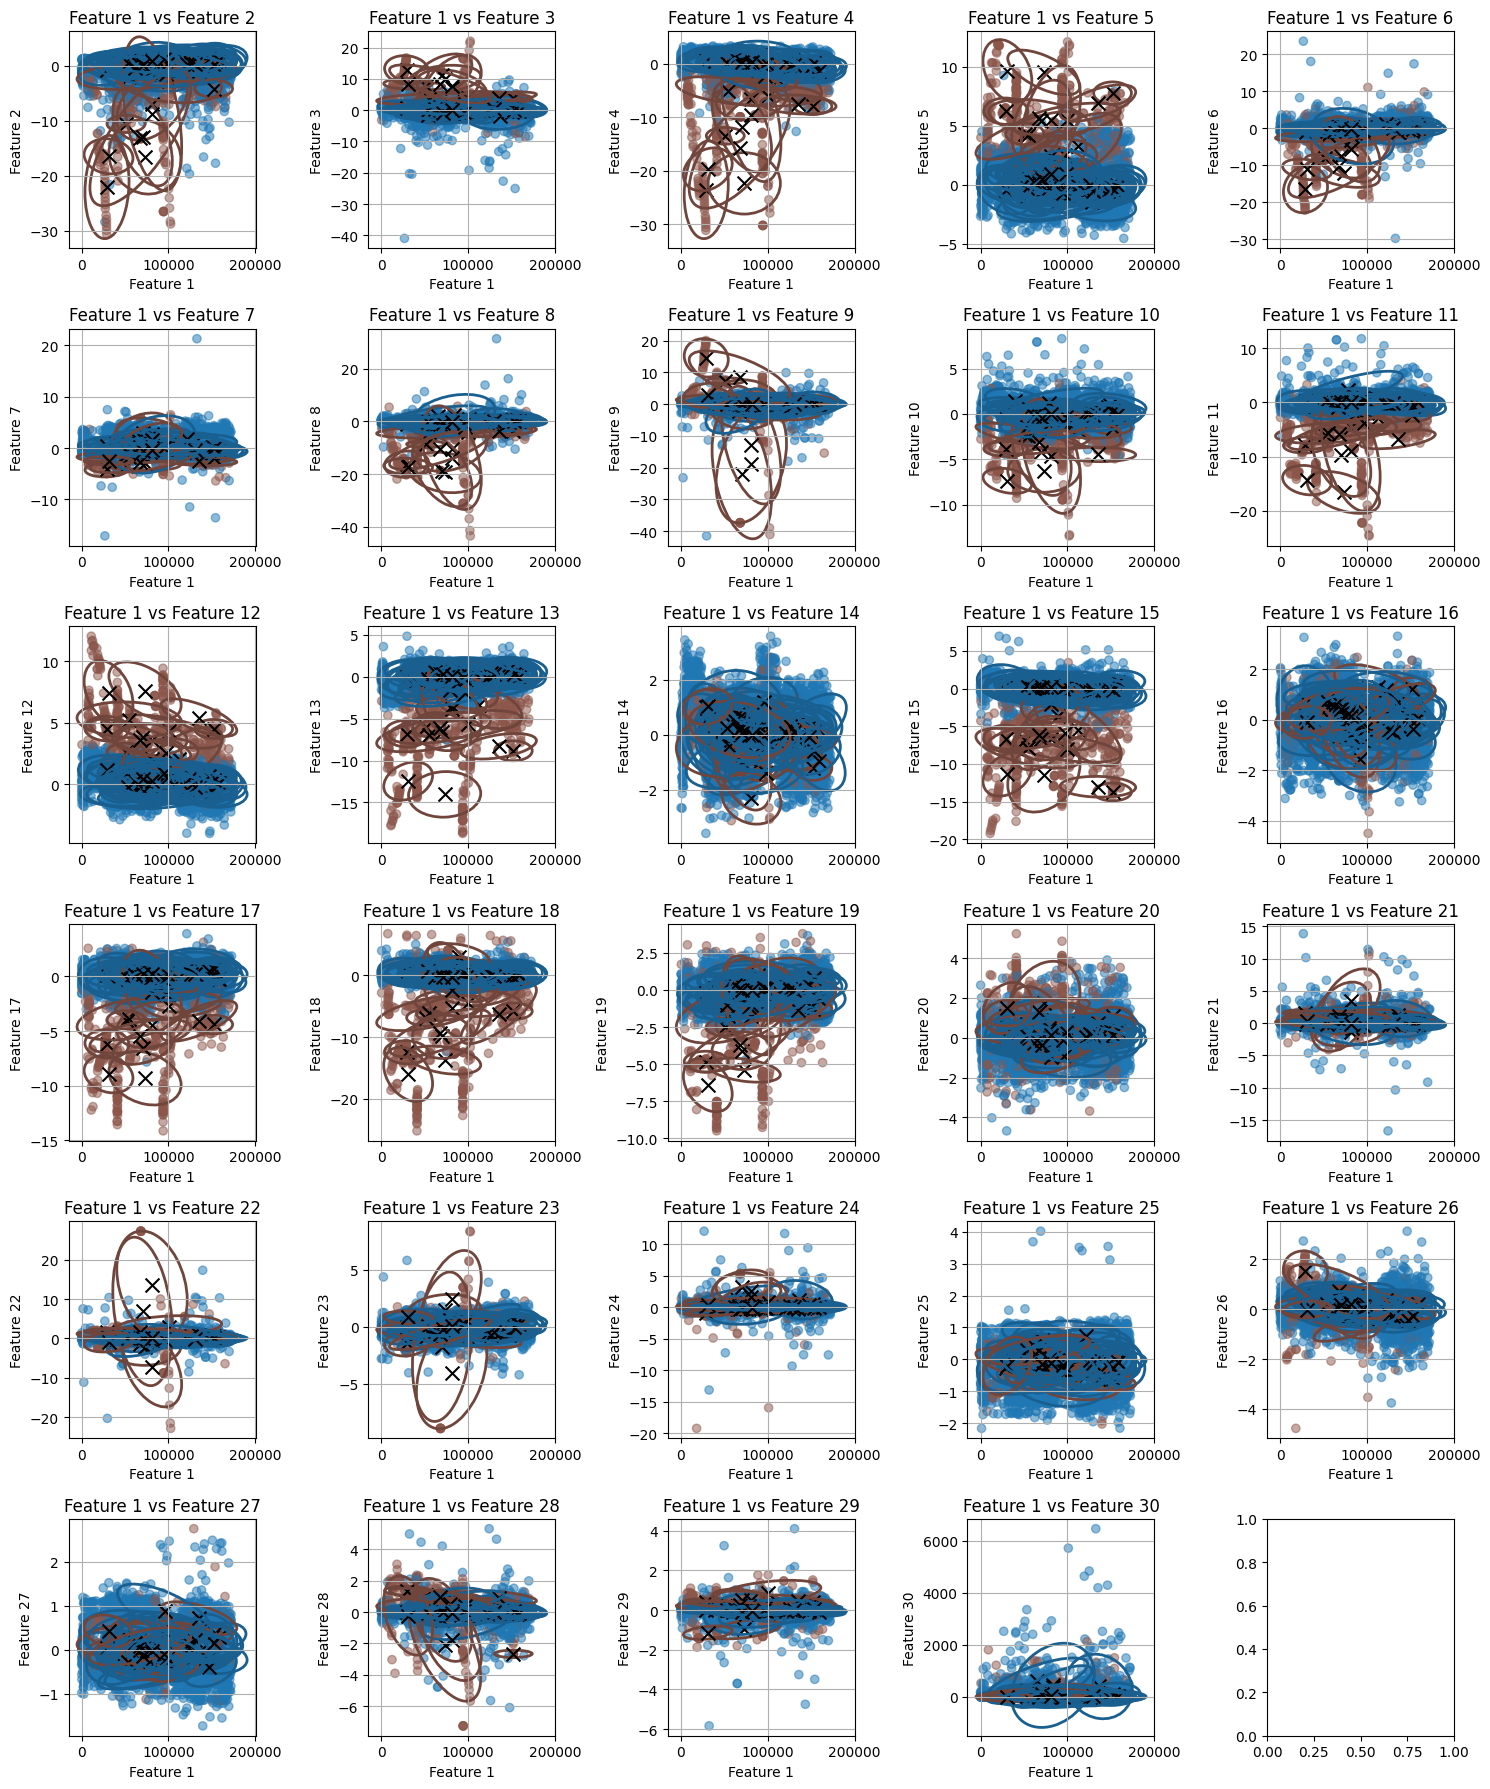


Testing federated model
Evolving has been disabled.


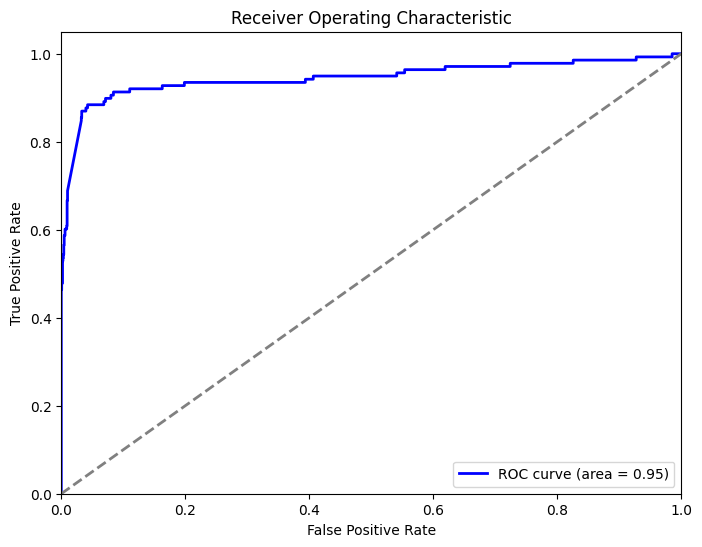

Test Metrics: {'accuracy': 0.958128078817734, 'precision': 0.9555568227245763, 'recall': 0.958128078817734, 'f1_score': 0.9546620842870529}
Test ROC AUC: 0.9451206429086937


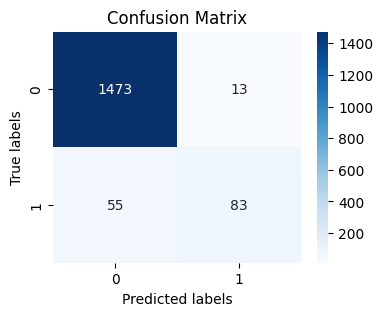

In [12]:

plot_first_feature(all_data, model=federated_model, num_sigma=federated_model.num_sigma, N_max=1)   

print(f"\nTesting federated model")   

all_scores, pred_max = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data)
roc_auc = calculate_roc_auc(all_scores, test_data)
#test_model(client_model, all_data)
print(f"Test Metrics: {metrics}")
print(f"Test ROC AUC: {roc_auc}")
#test_model(federated_model, all_data)


plot_confusion_matrix(pred_max, test_data)